In [35]:
from __future__ import print_function
import os
import sys
import cv2
import numpy as np
import scipy
import numpy.linalg as lin
from time import time

import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

In [36]:
# Create data matrix from a list of images
def createDataMatrix(images):
    print("Creating data matrix",end=" ... ")
    sz = images[0].shape # размеры
    data = np.zeros((numImages, sz[0] * sz[1]), dtype=np.float32) # создаем столько же нулевых матриц sz[2]-каналы?
    for i in range(0, numImages): # для каждой картинки
        image = images[i].flatten() #плющим
        data[i,:] = image #записываем в массив матриц
    
    print("DONE")

    return data

In [37]:
# Read images from the directory
def readImages(path):
    print("Reading images from " + path, end="...")
    # Create array of array of images.
    images = []
    # List all files in the directory and read points from text files one by one
    # Список всех файлов в каталоге и чтение точек из текстовых файлов по одному
    for filePath in sorted(os.listdir(path)):  # для каждого файла в папке
        fileExt = os.path.splitext(filePath)[1]
        if fileExt in [".jpg", ".jpeg"]:
         
            # Add to array of images
            imagePath = os.path.join(path, filePath)
            im = cv2.imread(imagePath,0) # читаем картинку
            im = cv2.resize(im,(1218,1620))
            
            if im is None :
                    print("image:{} not read properly".format(imagePath))
            else :
                    # Convert image to floating point
                    im = np.float32(im)/255.0
                    # Add image to list 
                    images.append(im) # в список его
                    # аугментация перевенутыми картинкаи 
                    # Flip image 
                    # imFlip = cv2.flip(im, 1);
                    # Append flipped image
                    # images.append(imFlip)

    # numImages = len(images) / 2  # т.к. после аугментации изображений стало в 2 раза больше;
    global numImages
    numImages = len(images)
    # Exit if no image found
    if numImages == 0 :
                print("No images found")
                sys.exit(0)

    print(str(numImages) + " файлов прочитано.")
    return images

In [39]:
# Add the weighted eigen faces to the mean face 
# Создаем новую картинку при изменении слайдера
def createNewFace(*args):
    # Start with the mean image
    # вспоминаем чему равна средняя картинка 
    output = averageFace
    
    # Add the eigen faces with the weights
    # Складываем собственные 
    for i in range(0, NUM_EIGEN_FACES):
        '''
        OpenCV does not allow slider values to be negative. 
        So we use weight = sliderValue - MAX_SLIDER_VALUE / 2
        ''' 
        sliderValues[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars");
        weight = sliderValues[i] - MAX_SLIDER_VALUE/2
        output = np.add(output, eigenFaces[i] * weight) #скадываем  собсвенное изображение с выходом
        #output = np.add(output, eigenFaces[i] * 1) #скадываем  собсвенное изображение с выходом


    # Display Result at 2x size
    #output = cv2.resize(output, (0,0), fx=2, fy=2)
    cv2.imshow("Result", output)


In [41]:
# Add the weighted eigen faces to the mean face 
# Создаем новую картинку при изменении слайдера
def createNewFace_AndDiff(*args):
    # Start with the mean image
    # вспоминаем чему равна средняя картинка 
    output = averageFace
    
    # Add the eigen faces with the weights
    # Складываем собственные 
    for i in range(0, NUM_EIGEN_FACES):
        '''
        OpenCV does not allow slider values to be negative. 
        So we use weight = sliderValue - MAX_SLIDER_VALUE / 2
        ''' 
        sliderValues[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars");
        weight = sliderValues[i] - MAX_SLIDER_VALUE/2
        output = np.add(output, eigenFaces[i] * weight) #скадываем  собсвенное изображение с выходом
        #output = np.add(output, eigenFaces[i] * 1) #скадываем  собсвенное изображение с выходом


    # Display Result at 2x size
    #output = cv2.resize(output, (0,0), fx=2, fy=2)
    im_16 = im.astype(np.int16)
    averageFace_16 = (output*255).astype(np.int16)
 
    frame_diff = np.subtract(im_16, averageFace_16)
    #дефекты могут быть наоборот - темными на светлом фоне
    frame_diff_reverse = np.subtract(averageFace_16, im_16)
    frame_diff[frame_diff < 0] = 0
    frame_diff = frame_diff.astype(np.uint8)
    
    cv2.imshow("Result", frame_diff)


In [42]:
def resetSliderValues(*args):
    for i in range(0, NUM_EIGEN_FACES):
        cv2.setTrackbarPos("Weight" + str(i), "Trackbars", MAX_SLIDER_VALUE/2);    
    createNewFace()

In [43]:
# Number of EigenFaces
NUM_EIGEN_FACES = 8

# Maximum weight
MAX_SLIDER_VALUE = 255

# Directory containing images
dirName = "try_4"

# Read images
images = readImages(dirName)

Reading images from try_4...10 файлов прочитано.


In [44]:
t0 = time()
# Size of images
sz = images[0].shape

# Create data matrix for PCA.
data = createDataMatrix(images)
print("done in %0.3fs" % (time() - t0)) # время выполнения

Creating data matrix ... DONE
done in 0.083s


Calculating PCA ...done in 0.510s


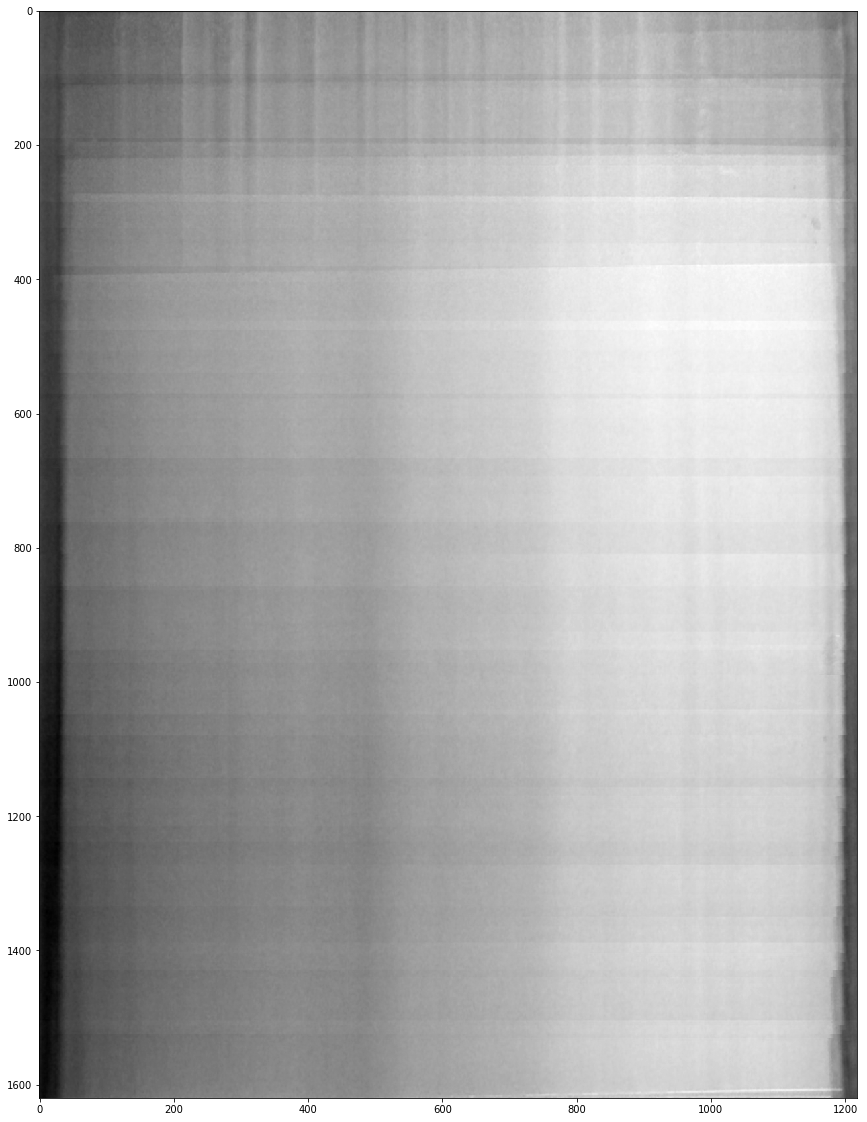

In [45]:
# Compute the eigenvectors from the stack of images created
print("Calculating PCA ", end="...")
# мы получаем сразу и среднее и собственные вектора
t0 = time()
mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_EIGEN_FACES)
print("done in %0.3fs" % (time() - t0)) # время выполнения

# прекраиваем среднее изображение из плоского массива в картинку
averageFace = mean.reshape(sz)
meanFace  = mean
#(1218,1620)
sz1 = (1620,1218,1)
#print(mean.reshape(sz1))
#gray_image = cv2.cvtColor(averageFace)
cv2.imwrite('gray.jpg', mean.reshape(sz1)*255)
plt.figure(figsize = (20,20))
# показать среднее изображение
plt.imshow(mean.reshape(sz)*255,cmap='gray')


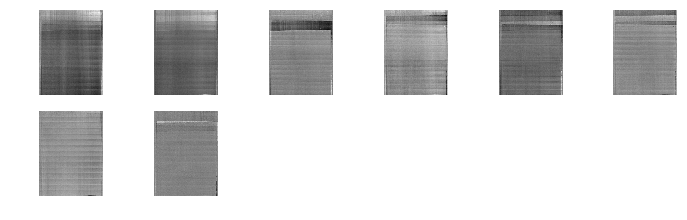

In [46]:
eigenFaces = []; 
k=0
N, R, C = 30, 5, 6
plt.figure(figsize=(12, 9))

for eigenVector in eigenVectors: # для каждого собственного вектора
    eigenFace = eigenVector.reshape(sz) # разворачиваем в картинку
    plt.subplot(R, C, k+1)
    plt.imshow(eigenFace, cmap='gray')
    plt.axis('off')
    k = k+1
    eigenFaces.append(eigenFace) # добавляем в список

[[67 68 67 ... 81 82 82]
 [67 68 68 ... 81 80 81]
 [68 68 68 ... 81 80 80]
 ...
 [44 44 44 ... 64 64 64]
 [44 44 44 ... 64 64 64]
 [44 44 43 ... 64 64 64]]
(2, 1620, 1218)


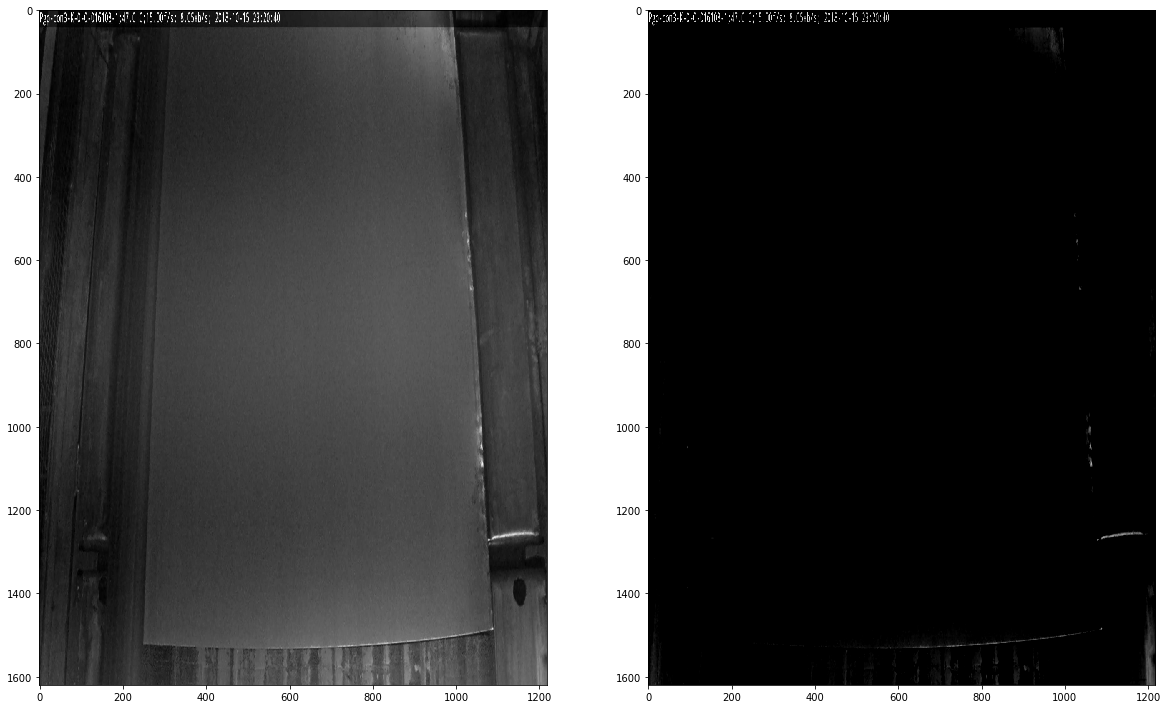

In [47]:
im = cv2.imread("Defect.jpg", 0) # читаем картинку
im = cv2.resize(im,(1218,1620))

im_16 = im.astype(np.int16)
averageFace_16 = (averageFace*255).astype(np.int16)
 
frame_diff = np.subtract(im_16, averageFace_16)
#дефекты могут быть наоборот - темными на светлом фоне
frame_diff_reverse = np.subtract(averageFace_16, im_16)
frame_diff[frame_diff < 0] = 0
frame_diff = frame_diff.astype(np.uint8)
 
images = []
images.append(im_16) # дефектное изображение
print(averageFace_16)
images.append(frame_diff)
print(np.shape(images))
 
fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 1
for i in range(0, len(images)):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(images[i], cmap='gray')
plt.show()

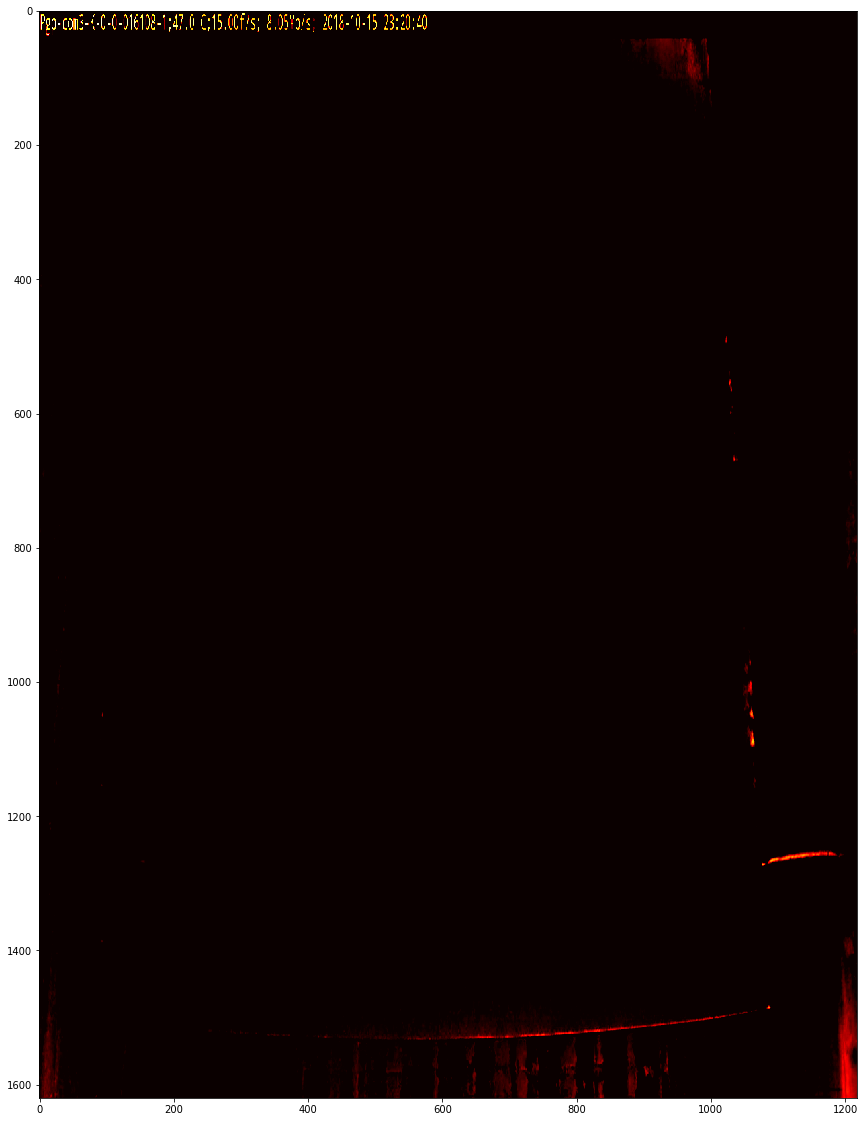

In [48]:
plt.figure(figsize = (20,20))
# показать среднее изображение
plt.imshow(frame_diff,cmap='hot')

# Лист нормальный

In [49]:
def draw_lists(weight0, weight1, weight2, weight3, weight4, weight5):
    output = averageFace
    output = np.add(output, eigenFaces[0] * weight0)
    output = np.add(output, eigenFaces[1] * weight1)
    output = np.add(output, eigenFaces[2] * weight2)
    output = np.add(output, eigenFaces[3] * weight3)
    output = np.add(output, eigenFaces[4] * weight4)
    output = np.add(output, eigenFaces[5] * weight5) 
        #output = np.add(output, eigenFaces[i] * 1) #скадываем  собсвенное изображение с выходом

    
    im = cv2.imread("out-024.jpg", 0) # читаем картинку
    im = cv2.resize(im,(1218,1620))

    # Display Result at 2x size
    #output = cv2.resize(output, (0,0), fx=2, fy=2)
    im_16 = im.astype(np.int16)
    averageFace_16 = (output*255).astype(np.int16)
 
    frame_diff = np.subtract(im_16, averageFace_16)
    #дефекты могут быть наоборот - темными на светлом фоне
    frame_diff_reverse = np.subtract(averageFace_16, im_16)
    frame_diff[frame_diff < 0] = 0
    frame_diff = frame_diff.astype(np.uint8)
    plt.figure(figsize = (17,17))
    #plt.imshow(frame_diff,cmap='hot')
    # cv2.imshow("Result", frame_diff)
    plt.imshow(frame_diff, cmap='hot')
    print(np.linalg.norm(im_16-averageFace_16))
    print("\n")


maxweight = 200.0

interactive_plot = interactive(draw_lists, weight0=(-maxweight, maxweight), weight1=(-maxweight, maxweight),
                               weight2=(-maxweight, maxweight), weight3=(-maxweight, maxweight), 
                               weight4=(-maxweight, maxweight), weight5=(-maxweight, maxweight))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot


interactive(children=(FloatSlider(value=0.0, description='weight0', max=200.0, min=-200.0), FloatSlider(value=…

# Лист дефектный

In [58]:
def draw_lists(weight0, weight1, weight2, weight3, weight4, weight5):
    output = averageFace
    output = np.add(output, eigenFaces[0] * weight0)
    output = np.add(output, eigenFaces[1] * weight1)
    output = np.add(output, eigenFaces[2] * weight2)
    output = np.add(output, eigenFaces[3] * weight3)
    output = np.add(output, eigenFaces[4] * weight4)
    output = np.add(output, eigenFaces[5] * weight5) 
        #output = np.add(output, eigenFaces[i] * 1) #скадываем  собсвенное изображение с выходом

    
    im = cv2.imread("try_4/plate_3.jpg", 0) # читаем картинку
    im = cv2.resize(im,(1218,1620))

    # Display Result at 2x size
    #output = cv2.resize(output, (0,0), fx=2, fy=2)
    im_16 = im.astype(np.int16)
    averageFace_16 = (output*255).astype(np.int16)
 
    frame_diff = np.subtract(im_16, averageFace_16)
    #дефекты могут быть наоборот - темными на светлом фоне
    frame_diff_reverse = np.subtract(averageFace_16, im_16)
    frame_diff[frame_diff < 0] = 0
    frame_diff = frame_diff.astype(np.uint8)
    frame_diff_reverse[frame_diff < 0] = 0
    frame_diff_reverse = frame_diff_reverse.astype(np.uint8)    
    plt.figure(figsize = (17,17))
    #plt.imshow(frame_diff,cmap='hot')
    # cv2.imshow("Result", frame_diff)
    
    plt.imshow(im, cmap='gray')
    print(np.linalg.norm(im_16-averageFace_16))
    print("\n")

maxweight = 200.0

interactive_plot = interactive(draw_lists, weight0=(-maxweight, maxweight), weight1=(-maxweight, maxweight),
                               weight2=(-maxweight, maxweight), weight3=(-maxweight, maxweight), 
                               weight4=(-maxweight, maxweight), weight5=(-maxweight, maxweight))
output = interactive_plot.children[-1]
output.layout.height = '580px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='weight0', max=200.0, min=-200.0), FloatSlider(value=…